# Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", message="DtypeWarning")
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator


# Load Dataframe

In [3]:
df = pd.read_csv(
    r"C:\Users\admin\OneDrive\Desktop\pharma project-6\Pharma-project-6\train.zip",
    low_memory=False
)


In [4]:
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [5]:
df.shape

(1017209, 9)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


In [7]:
df.dtypes

Store             int64
DayOfWeek         int64
Date             object
Sales             int64
Customers         int64
Open              int64
Promo             int64
StateHoliday     object
SchoolHoliday     int64
dtype: object

In [8]:
df.isnull().sum()

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

In [9]:
df.describe()


,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
mean,5.584297e+02,3.998341e+00,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01
std,3.219087e+02,1.997391e+00,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.800000e+02,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00
50%,5.580000e+02,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00
75%,8.380000e+02,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00
max,1.115000e+03,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00


# Data Preparation

In [10]:
# Filtering out rows where stores are closed or sales are zero
df_filtered = df[(df['Open'] != 0) & (df['Sales'] != 0)]

# Verify 'Date' column is present right before the conversion
print("Columns before conversion:", df_filtered.columns)


Columns before conversion: Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday'],
      dtype='object')


In [11]:

# Convert 'Date' column to datetime format
df_filtered['Date'] = pd.to_datetime(df_filtered['Date'])

# Group by 'Date' and sum 'Sales' for each date
sales_df = df_filtered.groupby('Date')['Sales'].sum().reset_index()

# Sort by 'Date' if needed (assuming you want the latest dates first for some reason)
sales_df = sales_df.sort_values(by='Date', ascending=False)

# Set 'Date' as index if needed for further time series analysis or plotting
sales_df.set_index('Date', inplace=True)

C:\Users\admin\AppData\Local\Temp\ipykernel_10912\4015733768.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Date'] = pd.to_datetime(df_filtered['Date'])


Filters out days on which stores were closed or had no sales.

Retains only the necessary columns for time series analysis ('Date' and 'Sales').

Converts the 'Date' column to the datetime type for time-based operations.

Groups the data by 'Date' and sums up the sales for each date, ensuring you get a total daily sales figure.

Sorts the data by date to ensure it's in chronological order, which is essential for time series forecasting.

Finally, sets the 'Date' column as the DataFrame index, which is standard practice for time series analysis to facilitate easier slicing and manipulation based on time.

In [12]:
# Verification of the resulting DataFrame
sales_df.head()


,Sales
Date,
2015-07-31,10109742
2015-07-30,8798854
2015-07-29,8499962
2015-07-28,9115073
2015-07-27,10707292


In [13]:
sales_df.shape

(942, 1)

In [14]:
#pd.set_option('display.max_rows', None)
sales_df = sales_df.sort_index()
time_series = sales_df['2013-01-01':'2015-07-31'].resample('W').sum()
time_series#.head()

,Sales
Date,
2013-01-06,26129335
2013-01-13,49275222
2013-01-20,34377765
2013-01-27,46040169
2013-02-03,38466029
...,...
2015-07-05,55690481
2015-07-12,41391282
2015-07-19,52008419


In [15]:
sales_df.columns

Index(['Sales'], dtype='object')

In [16]:
# Save the DataFrame to a CSV file
df.to_csv('sales_data.csv')

print("Data saved to 'sales_data.csv'.")

Data saved to 'sales_data.csv'.


# Time Series Analysis of Data 
##  Isolate the Time Series Data

C:\Users\admin\AppData\Local\Temp\ipykernel_10912\586022435.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ax.plot(y.resample('M').mean(),marker='o', markersize=8, linestyle='-', label='Monthly Mean Resample', color='red')


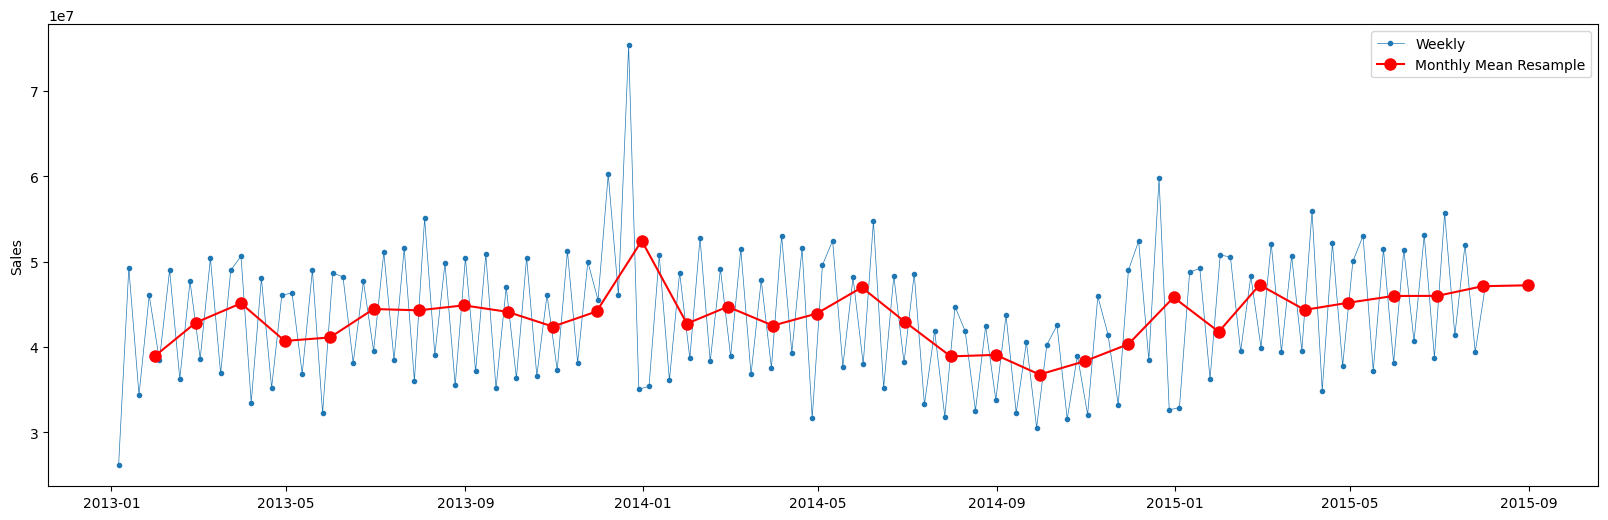

In [17]:
y = time_series['Sales'].copy()
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(y, marker='.', linestyle='-', linewidth=0.5, label='Weekly')
ax.plot(y.resample('M').mean(),marker='o', markersize=8, linestyle='-', label='Monthly Mean Resample', color='red')
ax.set_ylabel('Sales')
ax.legend();

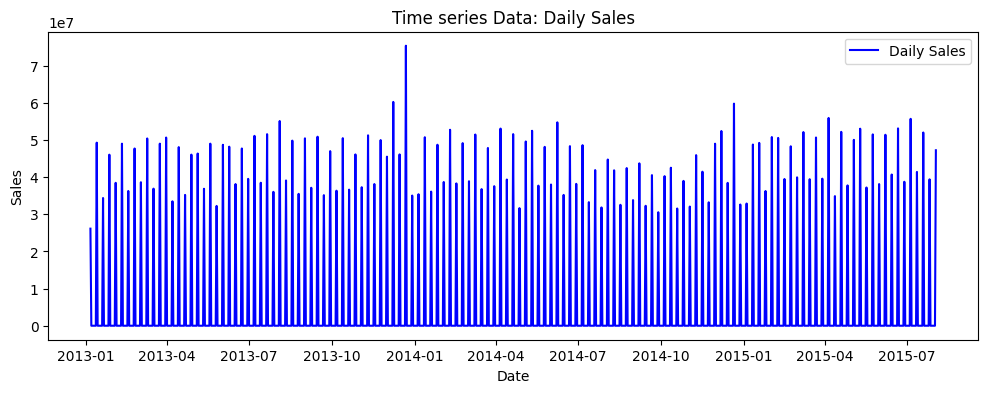

In [18]:
## Plotting the daily sales data
resample_df = y.resample('D').sum()
plt.figure(figsize=(12, 4))
plt.plot(resample_df, label='Daily Sales', color='blue')  # Set the color to blue
plt.title('Time series Data: Daily Sales')
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()

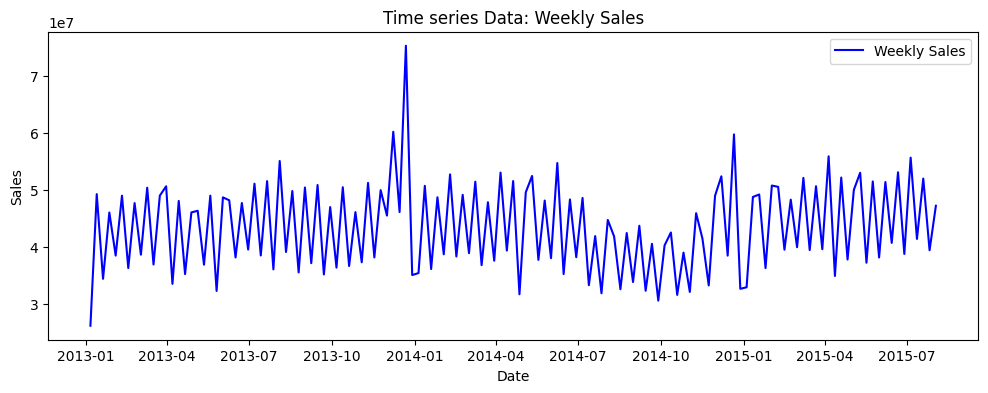

In [19]:
plt.figure(figsize=(12, 4))
plt.plot(y, label='Weekly Sales', color='blue')  # Set the color to blue
plt.title('Time series Data: Weekly Sales')
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()

<Axes: xlabel='Date'>

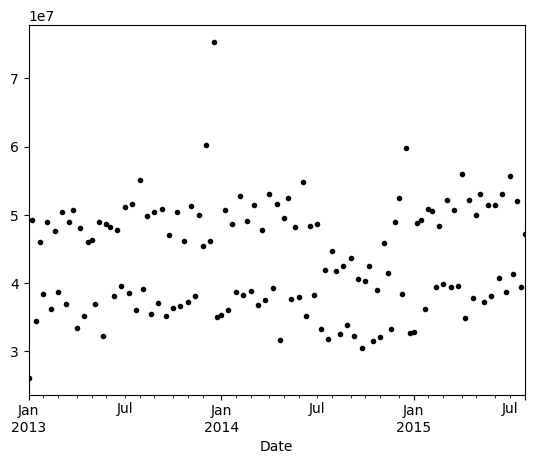

In [20]:
y.plot(style='k.')

<Axes: >

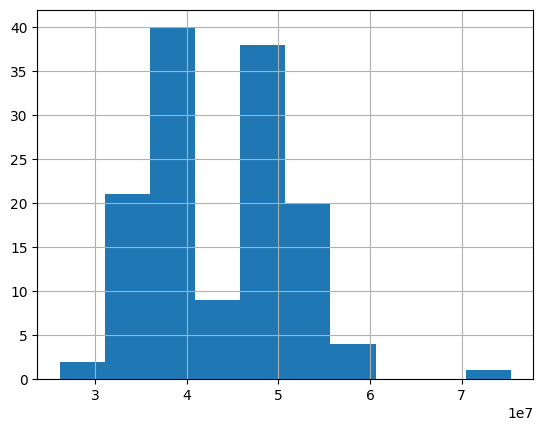

In [21]:
y.hist()

<Axes: ylabel='Density'>

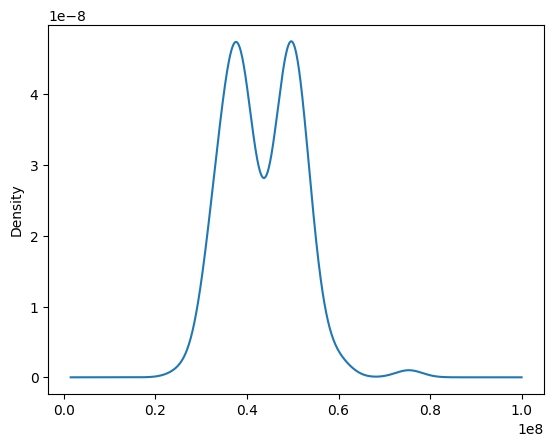

In [22]:
y.plot(kind='kde')

# 2.	Check whether your time Series Data is Stationary

In [23]:
# Using a smaller subset of the data
subset = df['Sales'].values[:10000]  # Adjust the size as per available memory
result = adfuller(subset, autolag='AIC')

In [24]:

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

# Interpretation
if result[1] > 0.05:
    print("The time series is not stationary")
else:
    print("The time series is stationary")

ADF Statistic: -2.948440
p-value: 0.039998
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
The time series is stationary


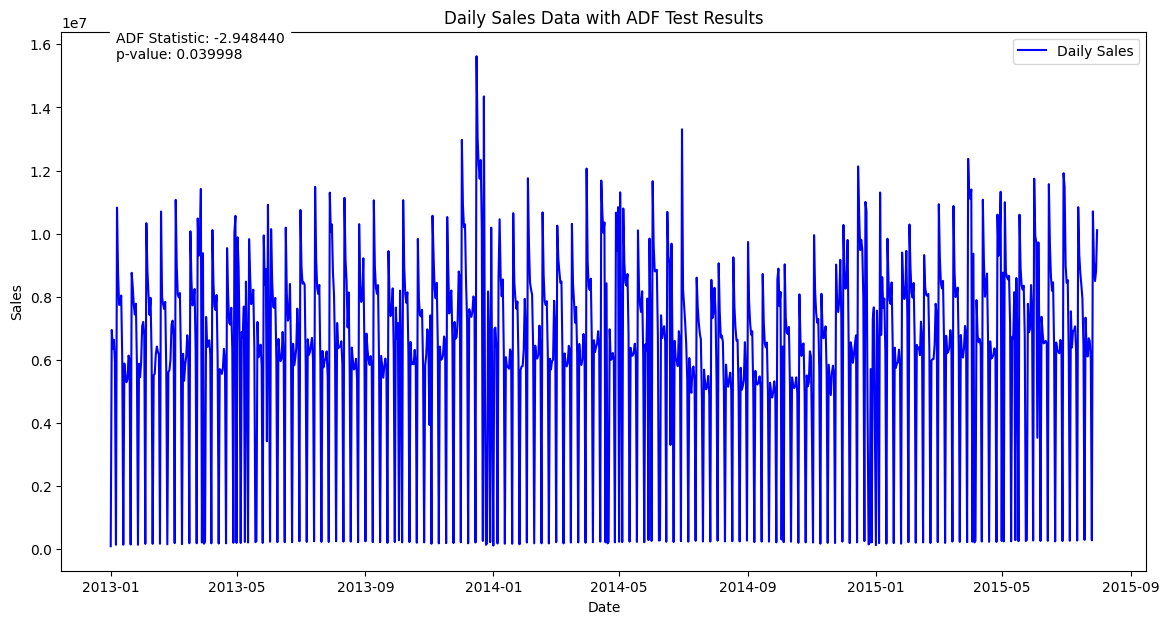

In [25]:
import matplotlib.pyplot as plt

# Assuming 'resample_df' is your DataFrame with daily sales data.
plt.figure(figsize=(14, 7))
plt.plot(sales_df, label='Daily Sales', color='blue')

# Highlighting the ADF Statistic and p-value in the plot
plt.annotate(f'ADF Statistic: -2.948440\np-value: 0.039998', xy=(0.05, 0.95), xycoords='axes fraction', backgroundcolor='white', fontsize=10)

plt.title('Daily Sales Data with ADF Test Results')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()


### Visualizing Stationarity

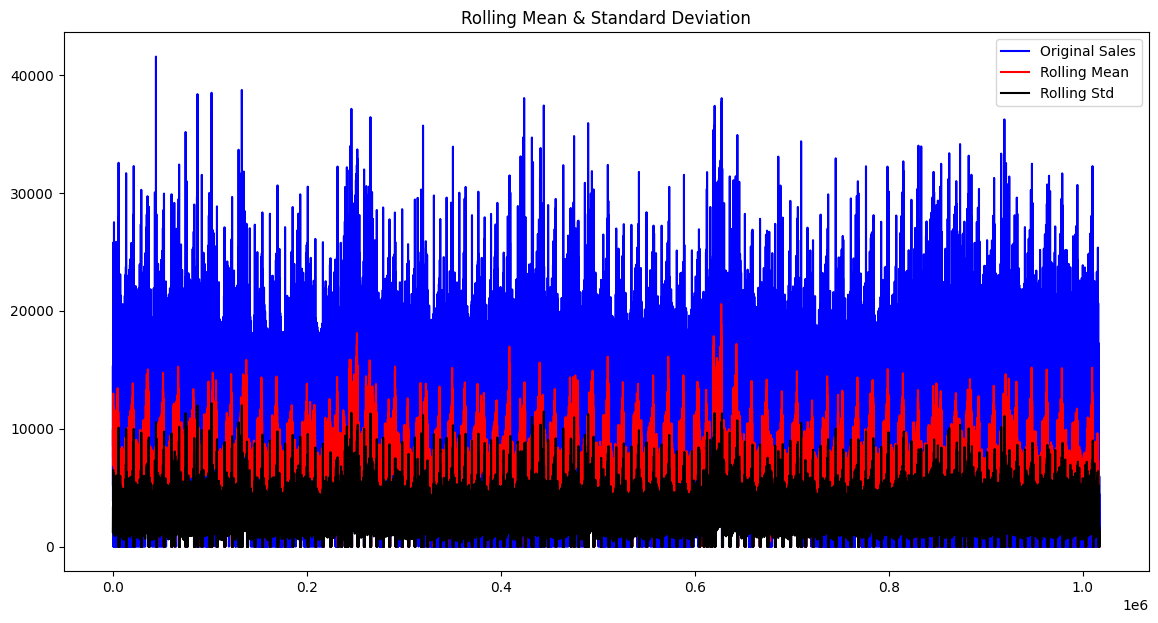

In [26]:
# Calculate rolling statistics
rolling_mean = df['Sales'].rolling(window=12).mean()
rolling_std = df['Sales'].rolling(window=12).std()

# Plot rolling statistics:
plt.figure(figsize=(14, 7))
plt.plot(df['Sales'], color='blue', label='Original Sales')
plt.plot(rolling_mean, color='red', label='Rolling Mean')
plt.plot(rolling_std, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show()


### Rolling means and standard deviation of our series
We were talking about how our mean and standard deviation should be constant over time in order to have a stationary time series, why not just plot this two properties?

In [27]:
window_size = 30  # This can be adjusted based on your dataset's frequency and characteristics

# Calculate rolling statistics
rolling_mean = resample_df.rolling(window=window_size).mean()
rolling_std = resample_df.rolling(window=window_size).std()
rolling_mean

Date
2013-01-06             NaN
2013-01-07             NaN
2013-01-08             NaN
2013-01-09             NaN
2013-01-10             NaN
                  ...     
2015-07-29    6.283077e+06
2015-07-30    6.283077e+06
2015-07-31    6.283077e+06
2015-08-01    6.283077e+06
2015-08-02    7.857441e+06
Freq: D, Name: Sales, Length: 939, dtype: float64

In [28]:
rolling_std

Date
2013-01-06             NaN
2013-01-07             NaN
2013-01-08             NaN
2013-01-09             NaN
2013-01-10             NaN
                  ...     
2015-07-29    1.649217e+07
2015-07-30    1.649217e+07
2015-07-31    1.649217e+07
2015-08-01    1.649217e+07
2015-08-02    1.805227e+07
Freq: D, Name: Sales, Length: 939, dtype: float64

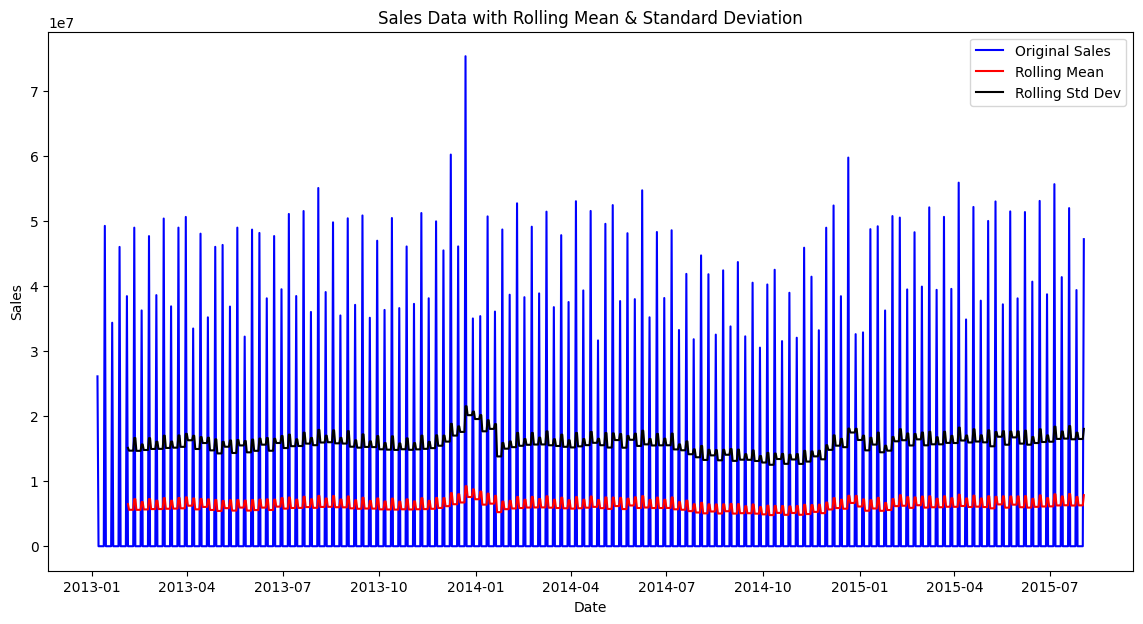

In [29]:
plt.figure(figsize=(14, 7))

# Plot original sales data
plt.plot(resample_df, color='blue', label='Original Sales')

# Plot rolling statistics
plt.plot(rolling_mean, color='red', label='Rolling Mean')
plt.plot(rolling_std, color='black', label='Rolling Std Dev')

plt.title('Sales Data with Rolling Mean & Standard Deviation')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend(loc='best')
plt.show()


In [30]:
### plot for Rolling Statistic for testing Stationarity
def test_stationarity(timeseries, title):
    
    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=12).mean() 
    rolstd = pd.Series(timeseries).rolling(window=12).std()
    
    fig, ax = plt.subplots(figsize=(16, 4))
    ax.plot(timeseries, label= title)
    ax.plot(rolmean, label='rolling mean');
    ax.plot(rolstd, label='rolling std (x10)');
    ax.legend()

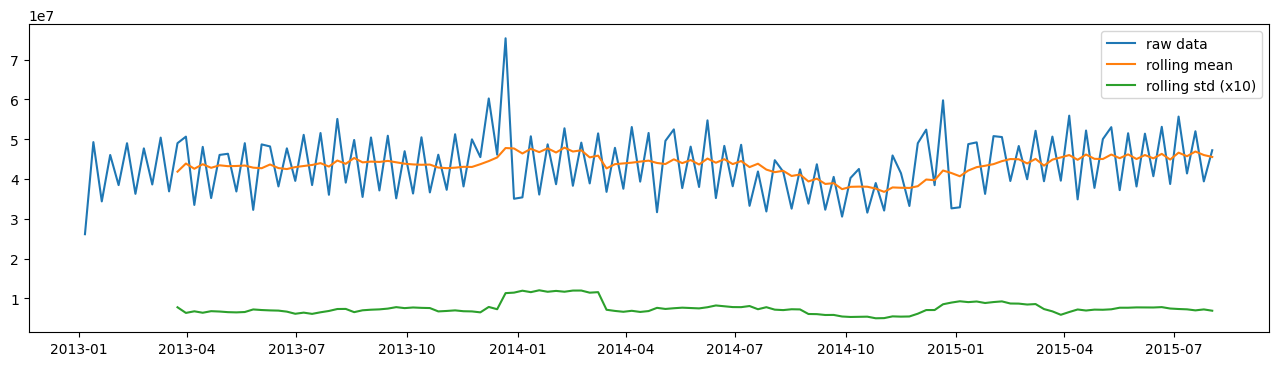

In [31]:
pd.options.display.float_format = '{:.8f}'.format
test_stationarity(y,'raw data')

### Interpreting the Plot
If the rolling mean and standard deviation are flat lines (constant over time), your series is likely stationary.
If they have a trend (upward or downward), your series is likely non-stationary.

In [32]:
from statsmodels.tsa.stattools import adfuller

# Augmented Dickey-Fuller Test
def ADF_test(timeseries, dataDesc):
    print(' > Is the {} stationary ?'.format(dataDesc))
    if isinstance(timeseries, np.ndarray):
        timeseries = pd.Series(timeseries)
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    print('Test statistic = {:.3f}'.format(dftest[0]))
    print('P-value = {:.3f}'.format(dftest[1]))
    print('Critical values :')
    for k, v in dftest[4].items():
        print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v, 'not' if v<dftest[0] else '', 100-int(k[:-1])))
ADF_test(y, 'raw data')

 > Is the raw data stationary ?
Test statistic = -3.902
P-value = 0.002
Critical values :
	1%: -3.481281802271349 - The data is  stationary with 99% confidence
	5%: -2.883867891664528 - The data is  stationary with 95% confidence
	10%: -2.5786771965503177 - The data is  stationary with 90% confidence


### KPSS Test

In [33]:
from statsmodels.tsa.stattools import kpss

def perform_kpss_test(time_series, **kw):
    statistic, p_value, lags, critical_values = kpss(time_series, **kw)
    
    print(f'KPSS Statistic: {statistic}')
    print(f'P-value: {p_value}')
    print('Critical Values:')
    for key, value in critical_values.items():
        print(f'   {key}: {value}')

    # Interpret the results
    if p_value <= 0.05:
        print("Result: Series is not stationary (reject the null hypothesis)")
    else:
        print("Result: Series is stationary (fail to reject the null hypothesis)")

# Perform the KPSS test
perform_kpss_test(time_series['Sales'], regression="ct", nlags="auto")

KPSS Statistic: 0.1581956878345857
P-value: 0.0398369268045119
Critical Values:
   10%: 0.119
   5%: 0.146
   2.5%: 0.176
   1%: 0.216
Result: Series is not stationary (reject the null hypothesis)


## Detrending
removes underlying trend of the time series

 > Is the de-trended data stationary ?
Test statistic = -7.829
P-value = 0.000
Critical values :
	1%: -3.4851223522012855 - The data is  stationary with 99% confidence
	5%: -2.88553750045158 - The data is  stationary with 95% confidence
	10%: -2.5795685622144586 - The data is  stationary with 90% confidence


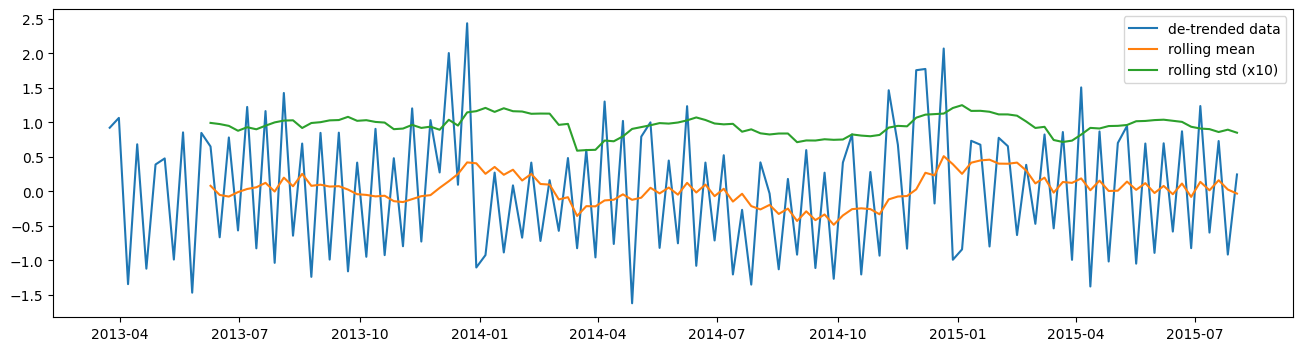

In [34]:
# Detrending
y_detrend =  (y - y.rolling(window=12).mean())/y.rolling(window=12).std()

test_stationarity(y_detrend,'de-trended data')
ADF_test(y_detrend,'de-trended data')

In [35]:
# Save the DataFrame to a CSV file
df.to_csv('Detrending_data.csv')

print("Data saved to 'Detrending_data.csv'.")

Data saved to 'Detrending_data.csv'.


# 3.	Depending on your conclusion from 2 above difference your time series data

#### First Difference

 > Is the First Differenced Data stationary ?
Test statistic = -8.342
P-value = 0.000
Critical values :
	1%: -3.482087964046026 - The data is  stationary with 99% confidence
	5%: -2.8842185101614626 - The data is  stationary with 95% confidence
	10%: -2.578864381347275 - The data is  stationary with 90% confidence


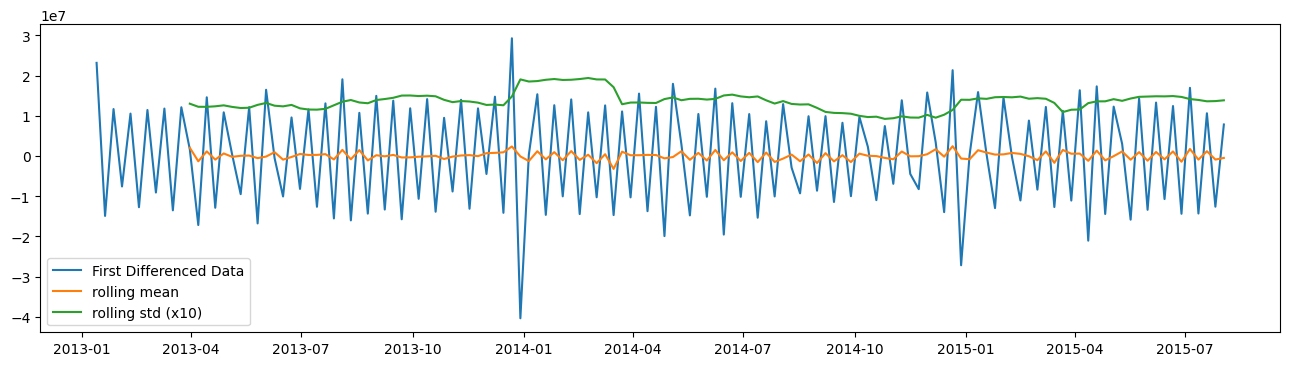

In [36]:
# Assuming 'y' is your original time series data.
y_diff = y.diff().dropna()

# Let's re-test stationarity on this differenced data
test_stationarity(y_diff, 'First Differenced Data')
ADF_test(y_diff, 'First Differenced Data')


#### Seasonal Differencing

 > Is the Seasonally Differenced Data stationary ?
Test statistic = -3.086
P-value = 0.028
Critical values :
	1%: -3.49181775886872 - The data is not stationary with 99% confidence
	5%: -2.8884437992971588 - The data is  stationary with 95% confidence
	10%: -2.5811201893779985 - The data is  stationary with 90% confidence


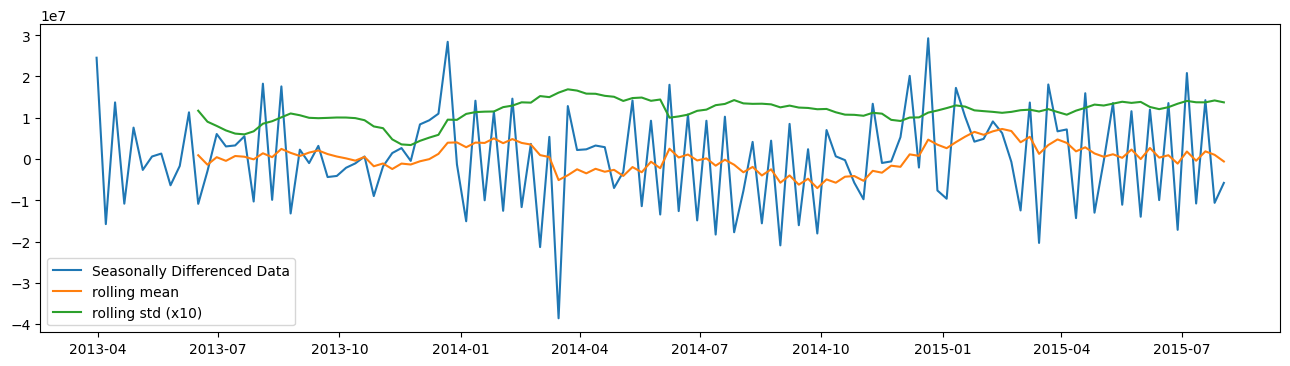

In [37]:
# Assuming a monthly seasonality, you can try seasonal differencing as follows:
seasonal_diff = y - y.shift(12)  # Assuming monthly data and a yearly seasonality
seasonal_diff = seasonal_diff.dropna()

# Re-test stationarity on this seasonally differenced data
test_stationarity(seasonal_diff, 'Seasonally Differenced Data')
ADF_test(seasonal_diff, 'Seasonally Differenced Data')


# 4.	Check for autocorrelation and partial autocorrelation of your data

Text(0.5, 1.0, 'Autocorrelation Function')

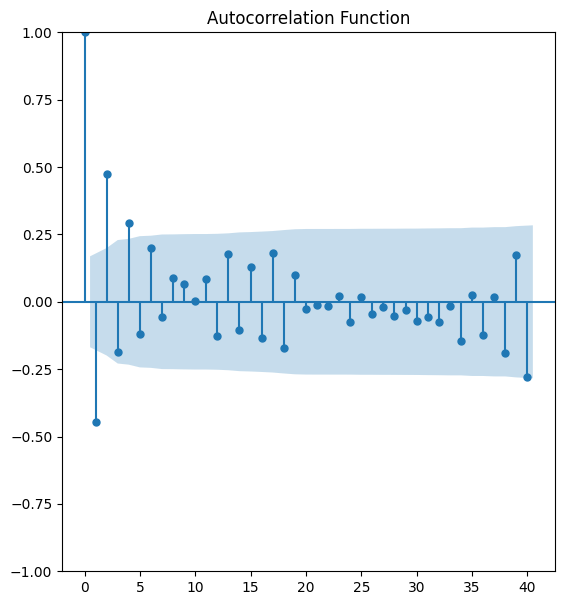

In [38]:
# Autocorrelation (ACF)
plt.figure(figsize=(14, 7))
plt.subplot(121)  # 1 row, 2 columns, first subplot
plot_acf(y, ax=plt.gca(), lags=40)  # You can adjust the number of lags as needed
plt.title('Autocorrelation Function')


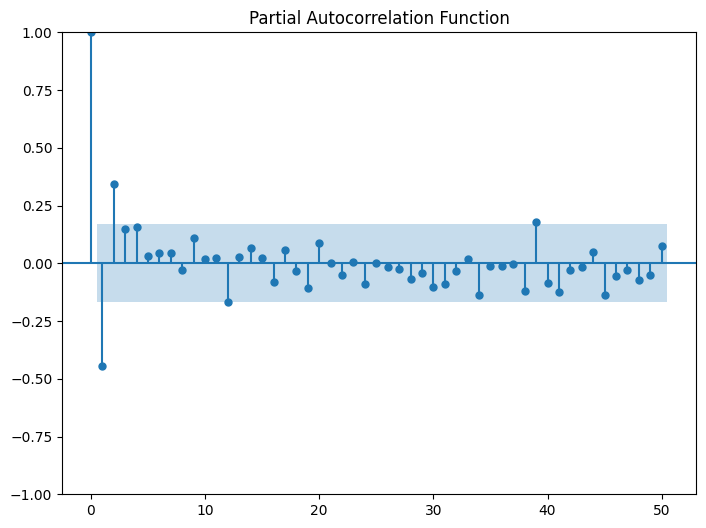

In [39]:

# Partial Autocorrelation (PACF)
plt.figure(figsize=(18, 6))  # Increase figure size; you can adjust the dimensions as needed

plt.subplot(122)  # 1 row, 2 columns, second subplot
plot_pacf(y, ax=plt.gca(), lags=50, method='ywm')  # You can adjust the number of lags as needed
plt.title('Partial Autocorrelation Function')

plt.show()

### Interpretation:

ACF (Autocorrelation Function): Shows the correlation between the time series with a lagged version of itself. For example, lag 1 autocorrelation is the correlation between values that are one time period apart.

PACF (Partial Autocorrelation Function): Shows the correlation between the time series and its lagged version, but after eliminating the variations explained by the in-between lags. It helps identify the order of the autoregressive (AR) terms in an ARIMA model.

# 5.	Transform the time series data into supervised learning data by creating a new y(target) column. For example as illustrated here in the Sliding Window For Time Series Data section 

In [40]:
# Assuming 'y' is your pandas Series or the target column in your DataFrame
y_to_train = y[:'2015-01-25']  # Training data
y_to_val = y['2015-02-01':]    # Validation data

# The number of data points for the validation set
predict_date = len(y) - len(y[:'2015-02-01'])


In [41]:
y.index

DatetimeIndex(['2013-01-06', '2013-01-13', '2013-01-20', '2013-01-27',
               '2013-02-03', '2013-02-10', '2013-02-17', '2013-02-24',
               '2013-03-03', '2013-03-10',
               ...
               '2015-05-31', '2015-06-07', '2015-06-14', '2015-06-21',
               '2015-06-28', '2015-07-05', '2015-07-12', '2015-07-19',
               '2015-07-26', '2015-08-02'],
              dtype='datetime64[ns]', name='Date', length=135, freq='W-SUN')

In [42]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    
    n_vars = 1 if type(data) is list else data.shape[0] if isinstance(data, pd.Series) else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()

    # Input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (1, i))]

    # Forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (1))]
        else:
            names += [('var%d(t+%d)' % (1, i))]

    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


In [43]:
# Assuming df is your DataFrame and 'Sales' is your column of interest
df = pd.Series([26129335, 49275222, 34377765, 46040169, 38466029, 55690481, 41391282, 52008419, 39402115, 47230923])
df

0    26129335
1    49275222
2    34377765
3    46040169
4    38466029
5    55690481
6    41391282
7    52008419
8    39402115
9    47230923
dtype: int64

In [44]:
n_in = 1  # Number of lag observations as input (X)
n_out = 1 # Number of observations as output (y), here we're predicting the next step

transformed_df = series_to_supervised(df, n_in, n_out)
print(transformed_df)

          var1(t-1)   var1(t)
1 26129335.00000000  49275222
2 49275222.00000000  34377765
3 34377765.00000000  46040169
4 46040169.00000000  38466029
5 38466029.00000000  55690481
6 55690481.00000000  41391282
7 41391282.00000000  52008419
8 52008419.00000000  39402115
9 39402115.00000000  47230923


# 6.	Scale your data in the (-1, 1) range

In [45]:
# Initialize the MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))

# Fit and transformed_df
scaled_data = scaler.fit_transform(transformed_df)

# Convert the scaled transformed_df back to a DataFrame for convenience
scaled_df = pd.DataFrame(scaled_data, columns=transformed_df.columns)

print(scaled_df)

    var1(t-1)     var1(t)
0 -1.00000000  0.39798766
1  0.56596683 -1.00000000
2 -0.44194112  0.09440805
3  0.34709487 -0.61635448
4 -0.16534400  1.00000000
5  1.00000000 -0.34184672
6  0.03256802  0.65447276
7  0.75088503 -0.52851152
8 -0.10201181  0.20614923



## Apply SARIMA (Seasonal AutoRegressive Integrated Moving Average) 
p: The number of lag observations included in the model (lag order).

d: The number of times that the raw observations are differenced (degree of differencing).

q: The size of the moving average window (order of moving average).

P: Seasonal autoregressive order.

D: Seasonal difference order.

Q: Seasonal moving average order.

s: The number of time steps for a single seasonal period.

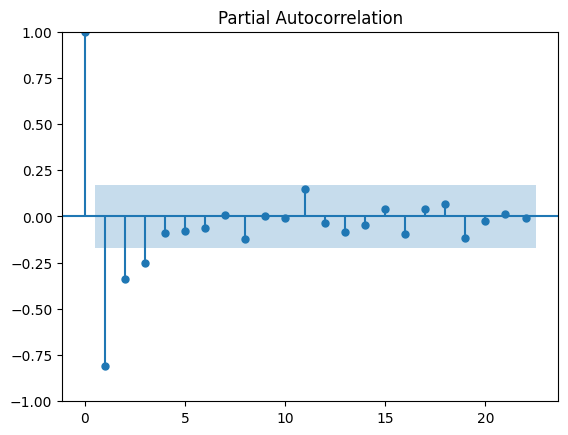

In [46]:
pacf_plot = plot_pacf(time_series['Sales'].diff()[1:])

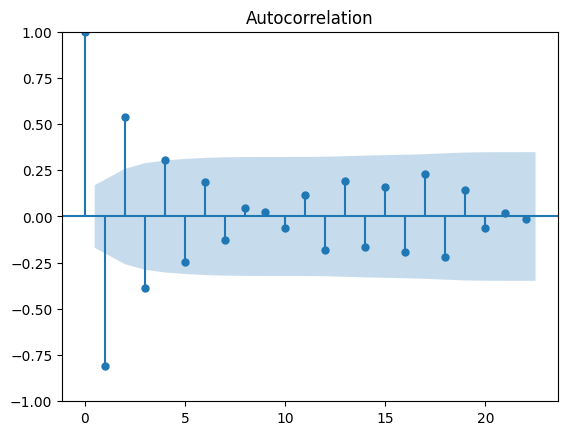

In [47]:
acf_plot = plot_acf(time_series['Sales'].diff()[1:])

In [48]:
# Example values for ARIMA and seasonal components
p = 1  # Number of lag observations (AR terms)
d = 1  # Degree of differencing
q = 1  # Size of moving average window

# Example values for seasonal components
P = 1  # Seasonal autoregressive order
D = 1  # Seasonal differencing order
Q = 1  # Seasonal moving average order
m = 12  # The number of time steps for a single seasonal period (e.g., 12 for monthly data with an annual cycle)

# Now that these variables are defined, you can specify the model orders
order = (p, d, q)
seasonal_order = (P, D, Q, m)

# Assuming 'y' is your time series data
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(y, order=order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
results = model.fit()

# Now you can print the summary, make predictions, etc.
print(results.summary())


                                     SARIMAX Results                                      
Dep. Variable:                              Sales   No. Observations:                  135
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1875.114
Date:                            Tue, 02 Apr 2024   AIC                           3760.227
Time:                                    22:47:39   BIC                           3773.638
Sample:                                01-06-2013   HQIC                          3765.665
                                     - 08-02-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6724      0.104     -6.482      0.000      -0.876      -0.469
ma.L1         -0.5110      0.204   

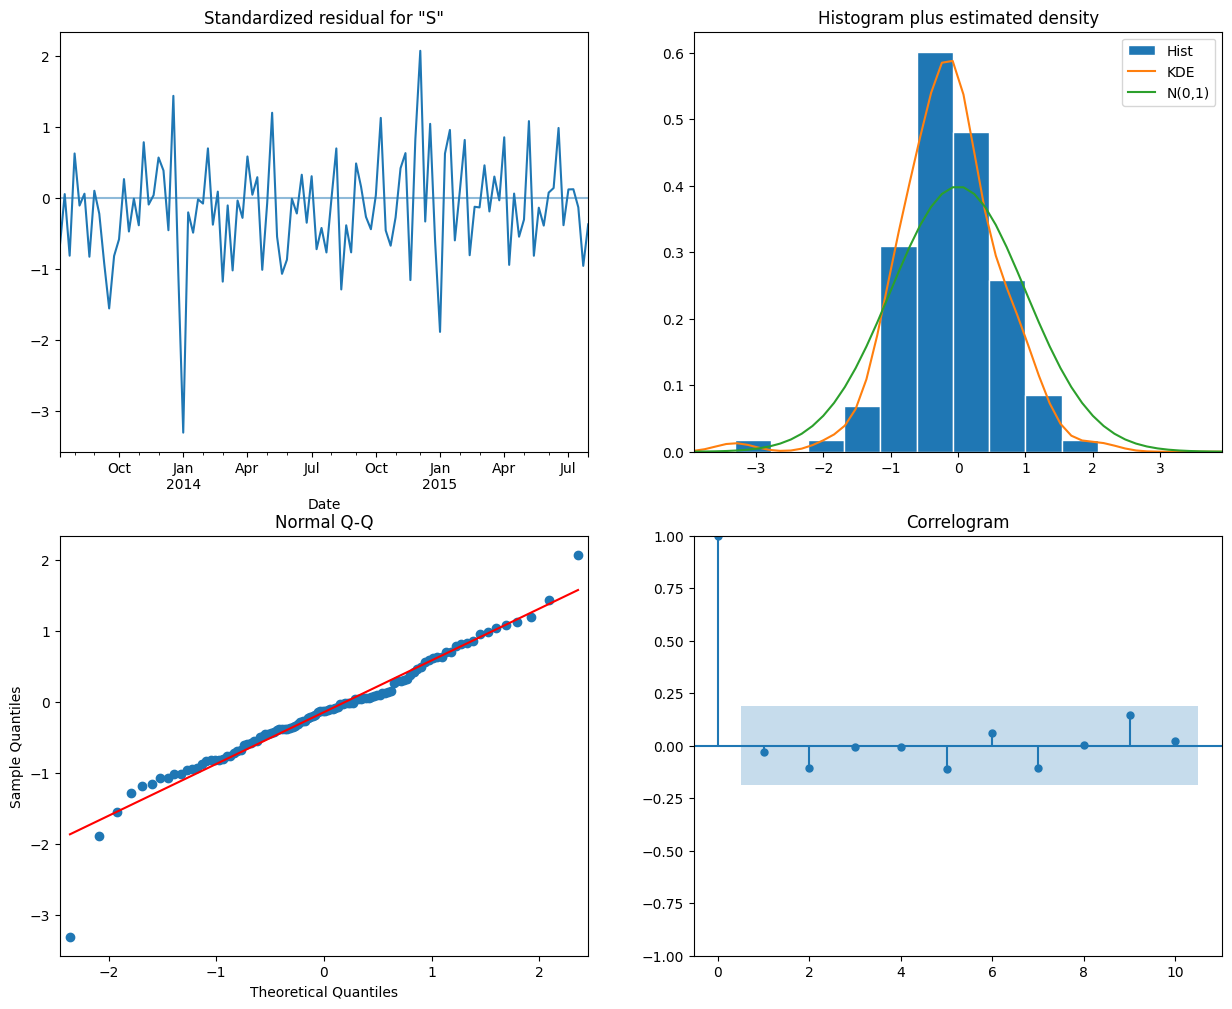

In [49]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()


## Model fitting, forecasting & evaluation

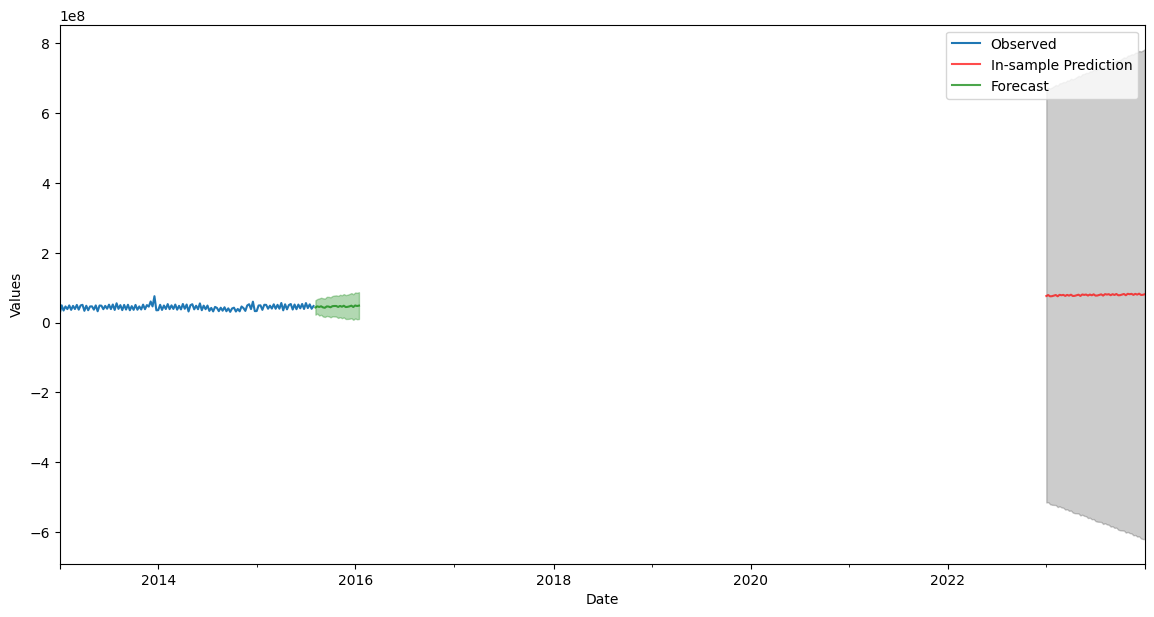

In [50]:
# Assuming you want to start predictions at '2023-01-01' and end at '2023-12-31'
# and your dataset has a DateTimeIndex
start_pred = '2023-01-01'
end_pred = '2023-12-31'

forecast_steps = 24  # Number of steps to forecast into the future

# In-sample predictions
pred = results.get_prediction(start=pd.to_datetime(start_pred), end=pd.to_datetime(end_pred), dynamic=False)
pred_conf_int = pred.conf_int()

# Out-of-sample forecast
forecast = results.get_forecast(steps=forecast_steps)
forecast_conf_int = forecast.conf_int()

# Plotting
ax = y.plot(label='Observed', figsize=(14, 7))
pred.predicted_mean.plot(ax=ax, label='In-sample Prediction', alpha=.7, color='red')
forecast.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7, color='green')

ax.fill_between(pred_conf_int.index,
                pred_conf_int.iloc[:, 0],
                pred_conf_int.iloc[:, 1], color='k', alpha=.2)
ax.fill_between(forecast_conf_int.index,
                forecast_conf_int.iloc[:, 0],
                forecast_conf_int.iloc[:, 1], color='green', alpha=.3)

ax.set_xlabel('Date')
ax.set_ylabel('Values')
plt.legend()
plt.show()


In [51]:
# Example with integer-based indexing
start_row = 10  # Starting from the 11th row (Python uses 0-based indexing)

# In-sample prediction
pred = results.get_prediction(start=start_row, dynamic=False)
pred_ci = pred.conf_int()
pred

In [52]:
pred_ci

,lower Sales,upper Sales
Date,,
2013-03-17,19105431.33300623,60226826.87569007
2013-03-24,26833759.10608678,67955154.64877215
2013-03-31,35512808.76891854,76634204.23261514
2013-04-07,40704218.22499666,81825613.70120618
2013-04-14,38731677.56955101,79853072.92847566
...,...,...
2015-07-05,33851786.66411728,74973181.41522431
2015-07-12,19527846.99677952,60649241.74788655
2015-07-19,32818899.12583816,73940293.87671046


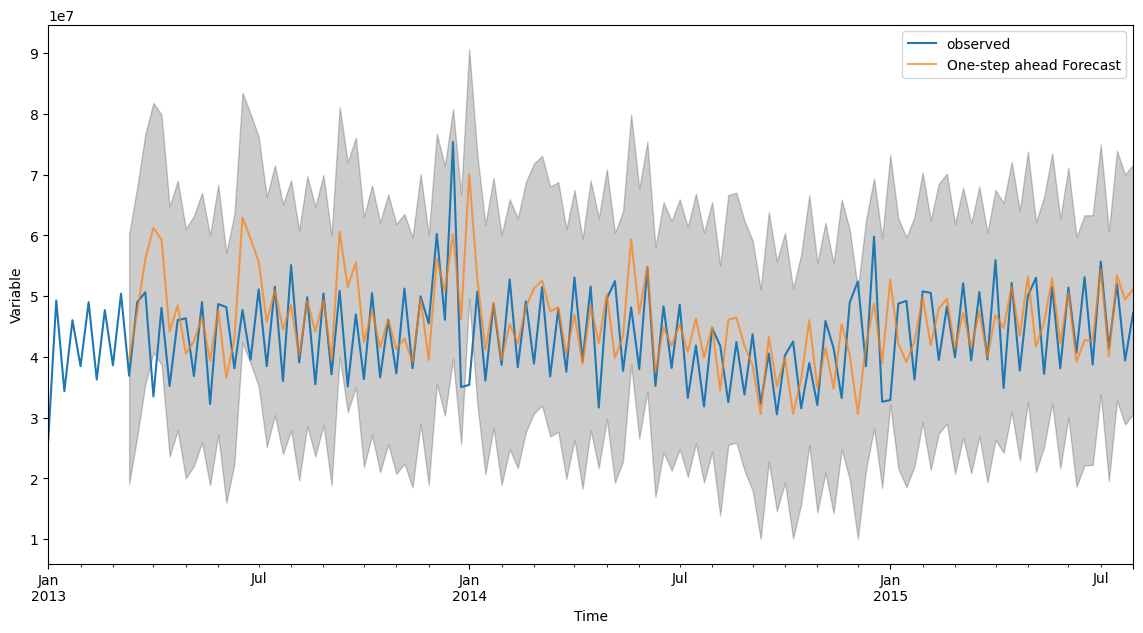

In [53]:
# Extract the real data for the period of the predictions
ax = y.plot(label='observed')

# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))

# Plot the confidence intervals
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Time')
ax.set_ylabel('Variable')
plt.legend()

plt.show()

In [54]:
from statsmodels.tools.eval_measures import rmse

# Assuming y_test is your test dataset and predictions is your model's predictions
y_forecasted = pred.predicted_mean
y_truth = y

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print(f'The Mean Squared Error of our forecasts is {mse}')


The Mean Squared Error of our forecasts is 68369212416748.62


# 7.	Build a LSTM Regression model to predict the next sale. 

In [55]:
# Mock-up dataset
data = {
    'Date': pd.date_range(start='2015-08-09', periods=6, freq='W'),
    'Sales': [42260953, 46360244, 43486838, 46567464, 42791970, 43515456]
}
df = pd.DataFrame(data)
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Scaling
scaler = MinMaxScaler(feature_range=(0, 1))
df['Sales'] = scaler.fit_transform(df[['Sales']])

In [56]:
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data)-seq_length):
        x = data.iloc[i:(i+seq_length)].values
        # No need to use .values for a scalar value
        y = data.iloc[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 3  # Number of time steps to look back
X, y = create_sequences(df['Sales'], seq_length)

# Ensure X is reshaped correctly for the LSTM model
X = X.reshape((X.shape[0], X.shape[1], 1))


##  Building the LSTM Model

In [57]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(seq_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')


c:\Users\admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [58]:
# Training the Model
model.fit(X, y, epochs=200, verbose=1)


Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.3495
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.3459
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.3423
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.3388
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.3353
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.3318
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.3283
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.3249
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.3215
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.3181
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.3147
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.3113
Epoch 13/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.3080
Epoch 14/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.3047
Epoch 15/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.3015
Epoch 16/200
1/1 ━━━━

In [59]:
# Save the DataFrame to a CSV file
df.to_csv('LSTM_model.csv')

print("Data saved to 'LSTM_model.csv'.")

Data saved to 'LSTM_model.csv'.


# Making Predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step


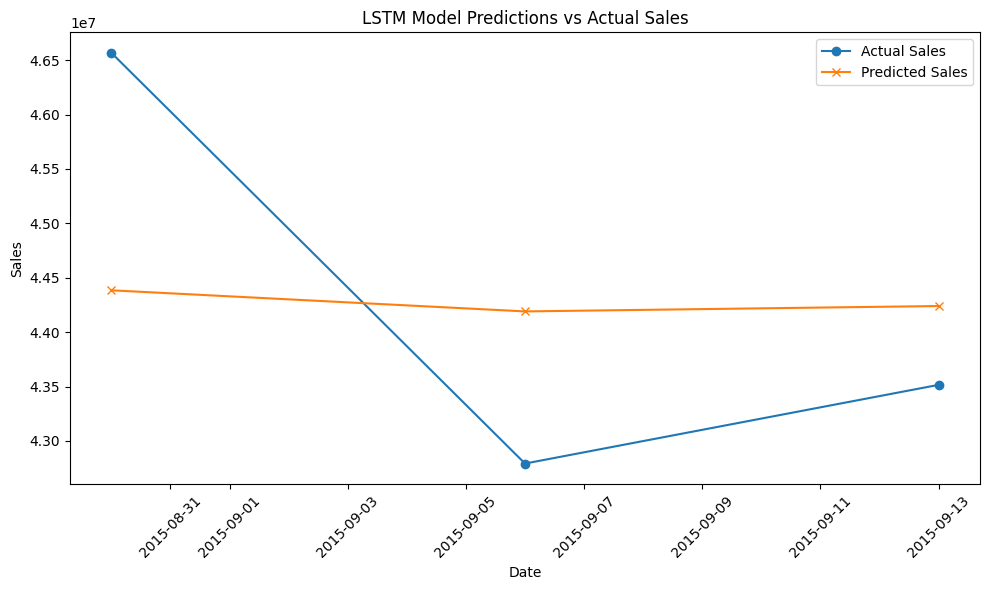

In [60]:
# Generate predictions
y_pred = model.predict(X)

# Invert scaling to original scale for interpretation
y_pred_rescaled = scaler.inverse_transform(y_pred)
y_actual_rescaled = scaler.inverse_transform(y.reshape(-1, 1))

# Create a DataFrame for plotting
results = pd.DataFrame({
    'Actual': y_actual_rescaled.flatten(),
    'Predicted': y_pred_rescaled.flatten()
}, index=df.index[-len(y_actual_rescaled):])  # Align the dates of the predictions

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(results['Actual'], label='Actual Sales', marker='o')
plt.plot(results['Predicted'], label='Predicted Sales', marker='x')
plt.title('LSTM Model Predictions vs Actual Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.xticks(rotation=45)  # Rotate dates for better visibility
plt.tight_layout()
plt.show()


In [61]:
results

,Actual,Predicted
Date,,
2015-08-30,46567464.00000000,44384612.00000000
2015-09-06,42791970.00000000,44190576.00000000
2015-09-13,43515456.00000000,44240064.00000000


### Predicts the sales using the LSTM model you've trained.
Rescales both predicted and actual sales values from the MinMaxScaler transformation back to their original scale, allowing for meaningful comparison.

Constructs a DataFrame results that contains both actual and predicted sales, aligning the predictions with the corresponding dates in your dataset.

Uses Matplotlib to plot both actual and predicted sales over time, providing a visual assessment of how well the LSTM model has captured the underlying trend and seasonality in the sales data.

In [63]:
# Save the results DataFrame to a CSV file
results.to_csv('lstm_model_predictions.csv', index=True)

print("CSV file 'lstm_model_predictions.csv' has been saved.")

CSV file 'lstm_model_predictions.csv' has been saved.
